# Creating A 2018 Forecast for Energy Consumption, and Solar and Wind Production

We will expand on the analysis performed in a previous notebook using the OPSD data, for Germany's Electricity consumption and production, by creating a forecast for 2018. This forecast will be for Germany's overall electricy consumption, as well as for wind and solar energy production. We will utilize Facebook's time series forecasting tool, Prophet. Prophet is a very powerful forecasting tool that excells with evenly spaced, daily data. It is capable of factoring holidays, seasons, etc.

## The Data

We will import the data and make the changes performed in the analysis notebook such that we are ready to perform time series operations on the data set.

In [1]:
# Import libraries/packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import fbprophet

# Display figures inline in Jupyter notebook
%matplotlib inline

# Use seaborn's style defaults, set default figure size
sns.set(rc={'figure.figsize':(11,5)})

In [2]:
# Read in the data as a time series, with date as the index and in Datetime type
opsd_daily = pd.read_csv('data/opsd_germany_daily.csv', index_col=0, parse_dates=True)

In [3]:
# Inspect the first 3 rows of the dataframe
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [4]:
# Inspect the last 3 rows of the dataframe
opsd_daily.tail(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2017-12-29,1295.08753,584.277,29.854,614.131
2017-12-30,1215.44897,721.247,7.467,728.714
2017-12-31,1107.11488,721.176,19.980,741.156


In [5]:
# Inspect shape of dataframe
opsd_daily.shape

(4383, 4)

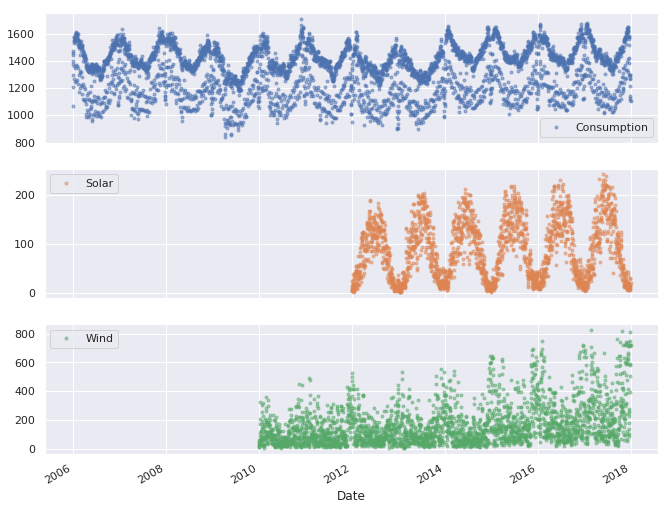

In [6]:
# Display a scatter plot of the full 3 time series in data set
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None',
                                 figsize=(11,9), subplots=True)
for ax in axes:
    ax.set_label('Daily Totals (GWh)')

A couple of observations from this figure that are also covered in more detail in the analysis notebook:

+ The data has weekly and yearly seasonality.
+ The year-over-year electricity consumption is relatively flat.
+ There is a slow growth trend in solar energy production.
+ There is a rapid growth trend in wind energy production.

A couple notes on Prophet's capabilities regarding the above abservations:
+ Prophet detects and allows for a lot of control over identifying trend changepoints (trajectory changes), though that may not need to come into play with these data sets.
+ Prophet can automatically fit weekly and yearly seasonaility (if series has more than two cycles).
+ Prophet natively models increases in mean and variance of the data over time; however, it is best is we take care to normalize the variance as much as we can to ensure we obtain the most accurate forecasts (Box-Cox, or some other power transform or normalizing method).

## Removing Noise With Box-Cox Transform

The Box-Cox transforms eveluate a set of $\lambda$-coefficients, selecting the value that achieves the optimal approximation of normalization. This method is preferred when in situations where it may be difficult to choose an appropriate normalization method (such as log transform, square root transform, etc.).

Scipy's Box-Cox power transform will return a positive, transformed data set, but it requires a 1-D array of positive data. It also allows you to explicitely declare a $\lambda$ value, otherwise it will automatically select a value that maximizes the log-likelihood fucntion, returning it as the second output arguement.

Since we are preparing forecasts for three different things (energy consumption, solar energy production and wind energy production), we will split the OPSD dataframe into three separate dataframes, each containing only the values for each item we wish to forecast. Then we will transform then with the Box-Cox method.

In [7]:
# Starting with overall consumption, declare new dataframe with only that data
df = opsd_daily[['Consumption']]

# Copy index (date) to the ds column
df['ds'] = df.index

/home/cjohn033/miniconda3/envs/py3-learn/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


##### Note: Prophet requires the input dataframe contains two columns named as "ds" and a "y." The "ds" column is the date field, which can be in datetime or date format. The "y" column is the value to be forecasted and must be in numeric format. The types can, and should, be checked prior to beginnning with fitting a forecast model.


In [8]:
df.dtypes

Consumption           float64
ds             datetime64[ns]
dtype: object

In [9]:
# Apply Box-Cox transform to new 'y' column
df['y'], lam = boxcox(df['Consumption'])

/home/cjohn033/miniconda3/envs/py3-learn/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


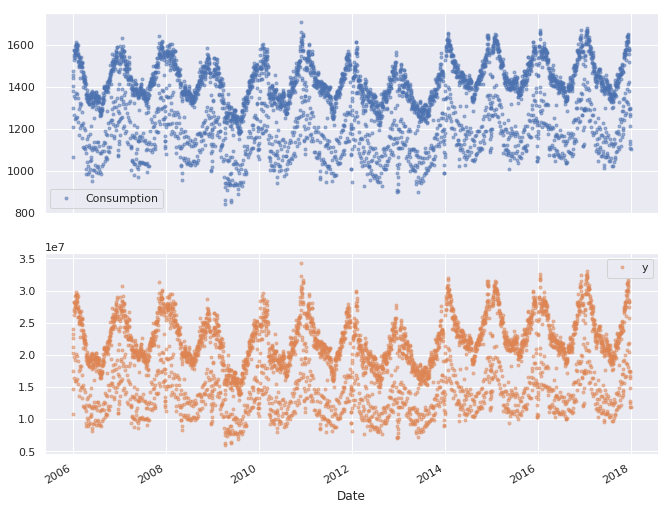

In [10]:
# Visual inspect that the transformation removed much of the noise
cols_plot = ['Consumption', 'y']
axes = df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None',
                                 figsize=(11,9), subplots=True);

The transformed data does not appear to have lost much, which does seem correct, as there was not any noticeable increasing variance in the original data.

## Forecasting

### Overall Consumption Forecast

In [11]:
# Instantiate a Prophet object
m = fbprophet.Prophet()

# Fit a model to the historic data
m.fit(df)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/cjohn033/miniconda3/envs/py3-learn/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Now that we have a model fit to the historic data we are able to begin forecasting for the future. Prophet has a function, make_future_dataframe, that simplifies this task for us. This function allows us to declare the frequency and number of periods we wish to forecast into the future. The data's default frequency is daily, therefore, we will leave the frequency input as its default value. Since we want to forecast for the entire year of 2018, and the frequency is daily, we will set the periods input arguement to 365, for 365 days (periods) into the future.

In [12]:
# Create dataframe for future values
future = m.make_future_dataframe(periods=365)

# Forecast for the future
forecast = m.predict(future)

Prophet has now created a new dataframe and assigned the forecast variable (the forecasted values for future dates) under the 'yhat' column. It has also provided fields for the uncertainty intervals and the forecast's components.

Let's visualize the forecast for 2018 along with the historic values.

In [13]:
# Inspect the first 3 rows of the new dataframe
forecast.head(3)

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2006-01-01,1.927109e+07,1.927109e+07,1.927109e+07,6.698643e+06,1.208173e+07,-9.916488e+06,-9.916488e+06,-9.916488e+06,0.0,0.0,0.0,-7.490734e+06,-7.490734e+06,-7.490734e+06,-2.425754e+06,-2.425754e+06,-2.425754e+06,9.354600e+06
1,2006-01-02,1.927222e+07,1.927222e+07,1.927222e+07,1.600718e+07,2.125644e+07,-5.120660e+05,-5.120660e+05,-5.120660e+05,0.0,0.0,0.0,1.617281e+06,1.617281e+06,1.617281e+06,-2.129347e+06,-2.129347e+06,-2.129347e+06,1.876015e+07
2,2006-01-03,1.927335e+07,1.927335e+07,1.927335e+07,1.785465e+07,2.333520e+07,1.200458e+06,1.200458e+06,1.200458e+06,0.0,0.0,0.0,2.973581e+06,2.973581e+06,2.973581e+06,-1.773123e+06,-1.773123e+06,-1.773123e+06,2.047380e+07


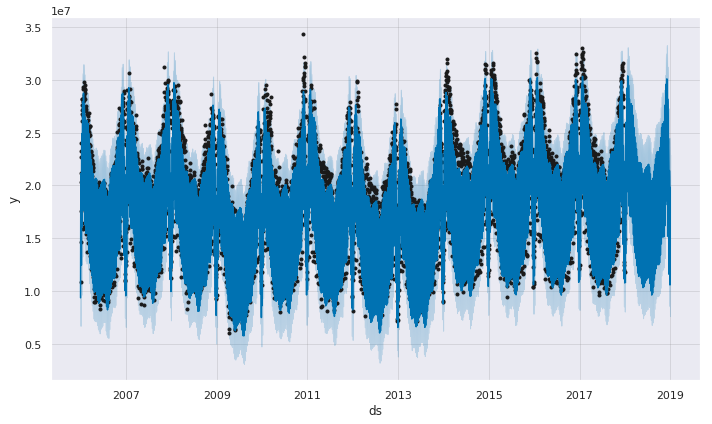

In [14]:
# Plot the forecast with Prophet's plot function
m.plot(forecast);

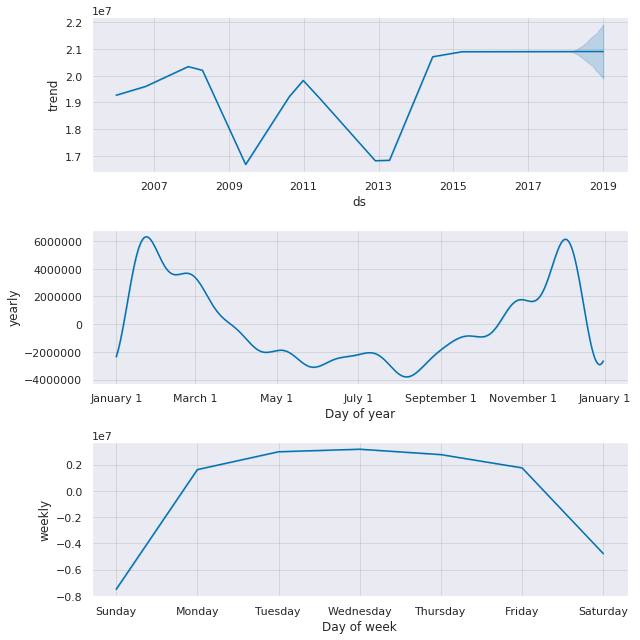

In [15]:
# Inspect forecast's components
m.plot_components(forecast);

Compared to the insights gained in the analysis notebook, Prophet was able to accurately model the underlying trend in the OPSD Consumption series, as well as the weekly and yearly trends (lower consumption furing summer months and also on weekends).

Since our data was transformed using the Box-Cox power transform before forecasting in Prophet we must remember to apply the inverse Box-COx transform to return to the original untis. Scipy's inverse Box-Cox method will require two inputs: an array of data that will be transformed and the $\lambda$ value we obtained from the original transform. We only nee to apply the inverse transform on specific columns in the forecast dataframe.

In [16]:
# Apply inverse Box-Cox transform to appropriate columns
forecast[['yhat', 'yhat_upper','yhat_lower']] = forecast[['yhat', 'yhat_upper', 'yhat_lower']].apply(lambda x: inv_boxcox(x, lam))

We can now visualize the actual forecast, in its original units, alongside the historic values.

In [17]:
# Make new dataframe with only date and yhat fields from forecast dataframe
consum_df = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']]

# Rename the columns
consum_df.columns = ['Date', 'Consumption', 'yhat_upper', 'yhat_lower']

# Set Date column as DatetimeIndex
consum_df = consum_df.set_index('Date')

# Inspect first 3 rows of new dataframe
consum_df.head(3)

,Consumption,yhat_upper,yhat_lower
Date,,,
2006-01-01,1005.508705,1116.107296,877.452591
2006-01-02,1335.549247,1405.369724,1251.832913
2006-01-03,1384.028297,1459.887455,1308.868428


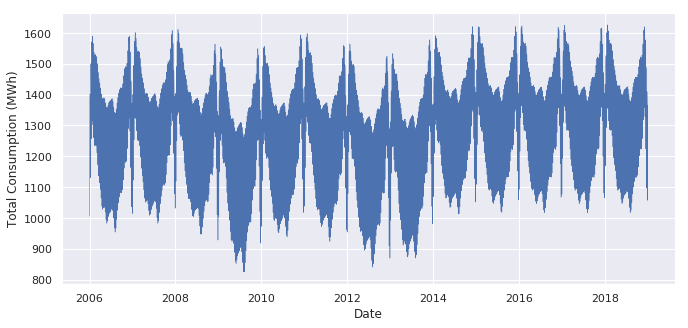

In [18]:
# Plot the actual forecast in original units with historic values
consum_df['Consumption'].plot(figsize=(11,5), linewidth=0.5)
plt.ylabel('Total Consumption (MWh)');